# Google Collaborator Setting 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
tcmalloc: large alloc 1073750016 bytes == 0x57368000 @  0x7fdb2c9f02a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
0.4.1
True


# Import

In [0]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,RandomSampler
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
from collections import OrderedDict
from itertools import islice
import json
from sklearn.model_selection import ParameterGrid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pyplot import xticks
from matplotlib.ticker import MultipleLocator
import random
import time
import pylab

# Read Traing and validation Data

In [0]:
snli_train = pd.read_csv('/content/drive/My Drive/nlp-hw2/hw2_data/snli_train.tsv',sep= "\t")
snli_val = pd.read_csv("/content/drive/My Drive/nlp-hw2/hw2_data/snli_val.tsv",sep= "\t")
mnli_train = pd.read_csv("/content/drive/My Drive/nlp-hw2/hw2_data/mnli_train.tsv",sep= "\t")
mnli_val = pd.read_csv("/content/drive/My Drive/nlp-hw2/hw2_data/mnli_val.tsv",sep= "\t")

d = {
    'neutral': 0,
    'entailment': 1,
    'contradiction': 2
}

snli_train["label"] = snli_train["label"].map(d)
snli_val["label"] = snli_val["label"].map(d)
mnli_train["label"] = mnli_train["label"].map(d)
mnli_val["label"] = mnli_val["label"].map(d)

# Read pre_trained fast text embedding matrix

In [190]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    cnt = 0
    for line in fin:
        cnt += 1
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
        if cnt == 50000:
            break
    return data

word_embeding_50002 = load_vectors("/content/drive/My Drive/nlp-hw2/wiki-news-300d-1M-subword.vec")
word_embeding_50002['<pad>'] = map(lambda x:x,[0]*300) ### padding's embedding vector is all 0
word_embeding_50002['<unk>'] = map(lambda x:x,[1]*300) ### unknown's embedding vector is all 1
print("Vocabulary size is:",len(word_embeding_50002)) ### some are capitalized

Vocabulary size is: 50002


# Token2ID, ID2Token

In [191]:
max_vocab_size = len(word_embeding_50002)
# save index 1 for unk and 0 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(vocab):
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(len(vocab)))) 
#     id2token = ['<pad>', '<unk>'] + id2token
#     token2id['<pad>'] = PAD_IDX 
#     token2id['<unk>'] = UNK_IDX
    return token2id, id2token   # token2id is the most important one

token2id, id2token = build_vocab(word_embeding_50002.keys())


# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        tokens = tokens.split(" ")
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

snli_train_sent1_indices = token2index_dataset(snli_train.sentence1)
snli_train_sent2_indices = token2index_dataset(snli_train.sentence2)
snli_val_sent1_indices = token2index_dataset(snli_val.sentence1)
snli_val_sent2_indices = token2index_dataset(snli_val.sentence2)

# double checking
print ("Train sentence1 size is {}".format(len(snli_train_sent1_indices)))
print ("Train sentence2 size is {}".format(len(snli_train_sent2_indices)))
print ("Val sentence1 size is {}".format(len(snli_val_sent1_indices)))
print ("Val sentence2 size is {}".format(len(snli_val_sent1_indices)))

Train sentence1 size is 100000
Train sentence2 size is 100000
Val sentence1 size is 1000
Val sentence2 size is 1000


# Make all tokens in vocabulary

In [0]:
word_embedingID_50002 = dict((token2id[k],v) for k,v in word_embeding_50002.items())
embedding_matrix = np.array([list(i) for i in word_embedingID_50002.values()]).reshape(50002,300)
embedding_matrix = torch.tensor(embedding_matrix)

# Build Data Loader

In [193]:
max_sent1_len = max([len(i) for i in snli_train_sent1_indices])
print("max_sent1_len:",max_sent1_len)
max_sent2_len = max([len(i) for i in snli_train_sent2_indices])
print("max_sent2_len:",max_sent2_len,"\n")


print("number of trainsentence1",len(snli_train_sent1_indices))
print("number of train sentence2",len(snli_train_sent2_indices))
train_targets = list(snli_train.label)
print("length of train target",len(train_targets),'\n')
val_targets = list(snli_val.label)
print("number of val sentence1",len(snli_val_sent1_indices))
print("number of val sentence2",len(snli_val_sent2_indices))
print("length of val target",len(val_targets))

max_sent1_len: 82
max_sent2_len: 41 

number of trainsentence1 100000
number of train sentence2 100000
length of train target 100000 

number of val sentence1 1000
number of val sentence2 1000
length of val target 1000


In [0]:
class VocabDataset(Dataset):
    def __init__(self, data1_list, data2_list, target_list):
        self.data1_list = data1_list
        self.data2_list = data2_list
        self.target_list = target_list
        assert (len(self.data1_list) == len(self.target_list))
        assert (len(self.data2_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.data1_list)
        
    def __getitem__(self, key):
        token1_idx = self.data1_list[key][:max_sent1_len]
        token2_idx = self.data2_list[key][:max_sent2_len]
        label = self.target_list[key]
        return [token1_idx,token2_idx, len(token1_idx), len(token2_idx),label]

def Vocab_collate_func(batch):
    data1_list = []
    data2_list = []
    label_list = []
    length1_list = []
    length2_list = []

    for datum in batch:   ### batch = sample
        label_list.append(datum[4])
        length2_list.append(datum[3])
        length1_list.append(datum[2])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_sent1_len-datum[2])),          ### 0代表左边没有pad,右边的值代表右边pad的个数
                                mode="constant", constant_values=0)
        data1_list.append(padded_vec1)
        
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_sent2_len-datum[3])),          ### 0代表左边没有pad,右边的值代表右边pad的个数
                                mode="constant", constant_values=0)
        data2_list.append(padded_vec2)
    return [torch.from_numpy(np.array(data1_list)).cuda(), torch.from_numpy(np.array(data2_list)).cuda(),torch.LongTensor(length1_list).cuda(), torch.LongTensor(length2_list).cuda(),torch.LongTensor(label_list).cuda()]

In [0]:
BATCH_SIZE = 32
train_dataset = VocabDataset(snli_train_sent1_indices,snli_train_sent2_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(snli_val_sent1_indices, snli_val_sent2_indices,val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Vocab_collate_func,
                                           shuffle=False)

# Embedding matrix and test model

In [0]:
## The function 'create_emb_layer' below refers from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
def create_emb_layer(weights_matrix, non_trainable=False):
    '''
    transfer the pre-trained embedding matrix to nn.embedding object that can be taken by RNN
    '''
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    weights_matrix = torch.tensor(weights_matrix).cuda()
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim
  
def test_model(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data1, data2,lengths1,lengths2, labels in loader:
        data_batch1,data_batch2, lengths_batch1,length_batch2, label_batch = data1, data2,lengths1,lengths2, labels
        outputs = F.softmax(model(data_batch1,data_batch2, lengths_batch1,length_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
#         print("Labels:",labels)
#         print("Prediction:",predicted.flatten())
#         print("incorrect prediction: {}".format(np.where(np.array(labels == predicted.flatten()) == 0)[0]))
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# Build a dataloader for subset training data

In [0]:
random.seed(2)
num_samples = 1000
subset_idx = random.sample([i for i in range(100000)], num_samples)
subset_train_dataset = []
for i in subset_idx:
    subset_train_dataset.append(train_dataset[i])
    
    
subset_train_loader = torch.utils.data.DataLoader(dataset=subset_train_dataset, 
                                           batch_size= num_samples,
                                           collate_fn=Vocab_collate_func,
                                           shuffle=True)

# RNN Model

In [0]:
class RNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        ### num_layers = 1, hidden_size = 200
        self.embedding, num_embeddings, emb_size = create_emb_layer(weights_matrix, non_trainable=True)
        ### embedding (50002*300)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
        ### this is for a small gru unit (300,200,2)
        self.fc1 = nn.Linear(hidden_size*4, hidden_size)
        ### hidden_size*4 due to two concat. first concat is to make bidirecetion 2 layer 2*32*200 to 1 layer 1*32*400
        ### second concat is to concat premise and hypothesis to combined vector
        ### so we have 1*32*400 + 1*32*400 = 1*32*800. Thats why we have hidden_size*4
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
        ### (200,3)
        
    def init_hidden(self, batch_size):
        
        hidden = torch.zeros(2*self.num_layers, batch_size, self.hidden_size)
        hidden = hidden.cuda()
#         hidden.zero_()
        # (2,batchsize,200)
        return hidden
    
    def forward(self, x1,x2, lengths1,lengths2): 
        ## x1 is batch_size by seq length 
        ## length1 is padded sequence
        batch_size, seq_len1 = x1.size()
        ## 32, 82
        batch_size, seq_len2 = x2.size()
        ## 32, 41
        self.hidden = self.init_hidden(batch_size)
        ## initialize a 2*32*200 hideen state, nothing to do with embedding
        _, idx1_sort = torch.sort(lengths1, dim=0, descending=True)
     
        
       
        ## length1 每一句话的长度，一个batch有32句话，所以length1 = 32，里面是每句话的长度的list. idx1_sort 1*32
        ## 假设length1 = [5,2,6] 那么_就是[6,5,2] 我们不需要. idx1_sort = [2,0,1],which is the new index we need
        _, idx1_unsort = torch.sort(idx1_sort, dim=0)
       
        ## idx1_sort = [2,0,1] _就是[2,1,0], idx1_unsort就是[0,2,1] 
        x1_sort = x1.index_select(0, idx1_sort) 
        x1_sort = x1_sort.cuda()
        ## x1 is input, 0 is dim, idx1_sort is index
        ## x1 32*82 x1_sort 32*82 但是里面的顺序根据idx1_sort改变了 最长的在x1_sort的最前面
        lengths1 = lengths1[idx1_sort].cpu()
        ## new length1 也根据idx1_sort改变了顺序 越前面的数字越大
#         print(self.embedding.weight.data[0])
        embed1 = self.embedding(x1_sort)
        ## self.embedding 50002 * 300, x1_sort 32*82, return 32*82*300 batch*sent_length*emb_size
        
                    
        
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1.numpy(), batch_first=True)
        embed1 = embed1.cuda()
        # The issue at hand is how to deal with variable length sequences in parallel. cuDNN has an implementation 
        # of the RNN models that computes the model efficiently, but requires a somewhat unusual format:  
        # time-sequence of variable-length batches rather than a batch-sequence of variable-length samples.
        
        # So there're two steps involved here. First, as you mentioned in collate_fn, we pad the sequences all to 
        # equal length accordingly, while also retaining a list of the actual lengths of the sequences. Then:
        
        # pack_padded_sequence does the conversion from your padded sequence to the format described above, 
        # hence packing it. Packing it requires PyTorch to know what the actual length of the sequence is, hence 
        # why we need to carry it around. If you inspect the packed output, it actually contains a rearrangement of 
        # your data as well as some metadata (lengths) to recover the original arrangement.
        # pad_packed_sequence does the reverse, which converts a packed sequence to the uniform-length 
        # padded-sequence.
        
        #One nice outcome is that when you run a packed sequence through an RNN in PyTorch, it returns both the 
        # complete history of outputs (in packed format), as well as the last hidden state corresponding to the 
        # correct length of each output. Because we're only interested in the latter, we do not actually need to 
        # run pad_packed_sequence.
        _, idx2_sort = torch.sort(lengths2, dim=0, descending=True)
  
        
        _, idx2_unsort = torch.sort(idx2_sort, dim=0)
       
        
        x2_sort = x2.index_select(0, idx2_sort)
        x2_sort = x2_sort.cuda()
        lengths2 = lengths2[idx2_sort].cpu()
        embed2 = self.embedding(x2_sort)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths2.numpy(), batch_first=True).cuda()
      
        _, self.hidden1 = self.gru(embed1, self.hidden)
        # https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm?rq=1
        ## _ is 当前层的forward y, 我们不需要。我们需要的是self.hidden1 parameter 2*32*200
        ## output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features (h_k) from the last layer of the RNN
        ## h_n (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for k = seq_len.
        _, self.hidden2 = self.gru(embed2, self.hidden)
        idx1_unsort = idx1_unsort.cuda()
        idx2_unsort = idx2_unsort.cuda()
               
        hidden1 = self.hidden1.index_select(1, idx1_unsort) # 对 2*32*200的32sort back回到最早的顺序 
        hidden2 = self.hidden2.index_select(1, idx2_unsort) # 也是为了匹配两个sentence
        

        hidden1_bi = torch.cat((hidden1[0], hidden1[1]), dim = 1)
        hidden1_bi = hidden1_bi.cuda()
        # 2*32*200 [0]是取到了 [0]32*200 [1]是 [1]32*200 最终变成了32*400 dim=1是沿着column增加
        hidden2_bi = torch.cat((hidden2[0], hidden2[1]), dim = 1)
        hidden2_bi = hidden2_bi.cuda()

        combined_vector = torch.cat([hidden1_bi, hidden2_bi], dim=1)
        combined_vector = combined_vector.cuda() # 32*400 + 32*400 = 32*800
        
#         combined_vector = combined_vector.reshape(batch_size,self.hidden_size*2)

        fc1_output = self.fc1(combined_vector) # 32*800 到 32*200
        non_linear = self.relu(fc1_output)    # 32*200 到 32*200
        fc2_output = self.fc2(non_linear)     # 32*200 到 32*3
        
        return fc2_output
      


def tuningRNN(hidden_size):
    learning_rate = 3e-4
    num_epochs = 20 # number epoch to train


    # Train the model
    model = RNN(embedding_matrix, hidden_size = hidden_size, num_layers = 1, num_classes = 3)
    model = model.cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc_list =[]
    val_acc_list = []
    highest_val_acc = 0
    
    for epoch in range(num_epochs):
        train_acc_list.append([])
        val_acc_list.append([])
        for i, (data1, data2,lengths1,lengths2, labels) in enumerate(train_loader): 
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2,lengths1,lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            if i > 0 and i % 300 == 0:
                # validate
                train_acc = test_model(subset_train_loader, model)
                val_acc = test_model(val_loader, model)
                if val_acc > highest_val_acc:
                    highest_val_acc = val_acc
                    torch.save(model.state_dict(), "/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize{}".format(hidden_size))
                    
                train_acc_list[epoch].append(float(train_acc))
                val_acc_list[epoch].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], train_acc: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), float(train_acc),val_acc))
    idx = val_acc_list.index(max(val_acc_list))
    print("The best model is with train_acc: {}, Validation Acc: {}".format(train_acc_list[idx],val_acc_list[idx]))
    
    return train_acc_list,val_acc_list
  

    


# Tuning RNN Hyper-parameter

In [0]:
grid = {'hidden_size':[400,500]}
num_comb = len(ParameterGrid(grid))

count = 0

for j in range(len(ParameterGrid(grid))):
    count += 1
    print("Now it is {} out of {} combinations".format(count, num_comb))
    for hidden_size in ParameterGrid(grid)[j].values():
        myCsvRow = "hidden_size = {}".format(hidden_size)
        print(myCsvRow)
        RNN_train, RNN_val = tuningRNN(hidden_size)
        pkl.dump(RNN_train, open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize{}.p".format(hidden_size),'wb'))
        pkl.dump(RNN_val, open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize{}.p".format(hidden_size),'wb'))
        

# Restore RNN

In [213]:
loaded_model = RNN(embedding_matrix, hidden_size = 500, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize500"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))



loaded_model = RNN(embedding_matrix, hidden_size = 400, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize400"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = RNN(embedding_matrix, hidden_size = 300, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize300"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = RNN(embedding_matrix, hidden_size = 200, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize200"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = RNN(embedding_matrix, hidden_size = 100, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize100"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

66.4
number of trained parameters: 3408003
67.8
number of trained parameters: 2326403
66.4
number of trained parameters: 1444803
67.2
number of trained parameters: 763203
66.2
number of trained parameters: 281603


In [0]:
RNN_train_hiddenSize500 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize500.p", "rb"))
RNN_train_hiddenSize400 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize400.p", "rb"))
RNN_train_hiddenSize300 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize300.p", "rb"))
RNN_train_hiddenSize200 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize200.p", "rb"))
RNN_train_hiddenSize100 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize100.p", "rb"))

RNN_val_hiddenSize500 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize500.p", "rb"))
RNN_val_hiddenSize400 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize400.p", "rb"))
RNN_val_hiddenSize300 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize300.p", "rb"))
RNN_val_hiddenSize200 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize200.p", "rb"))
RNN_val_hiddenSize100 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize100.p", "rb"))

# RNN Train Accuracy Plot

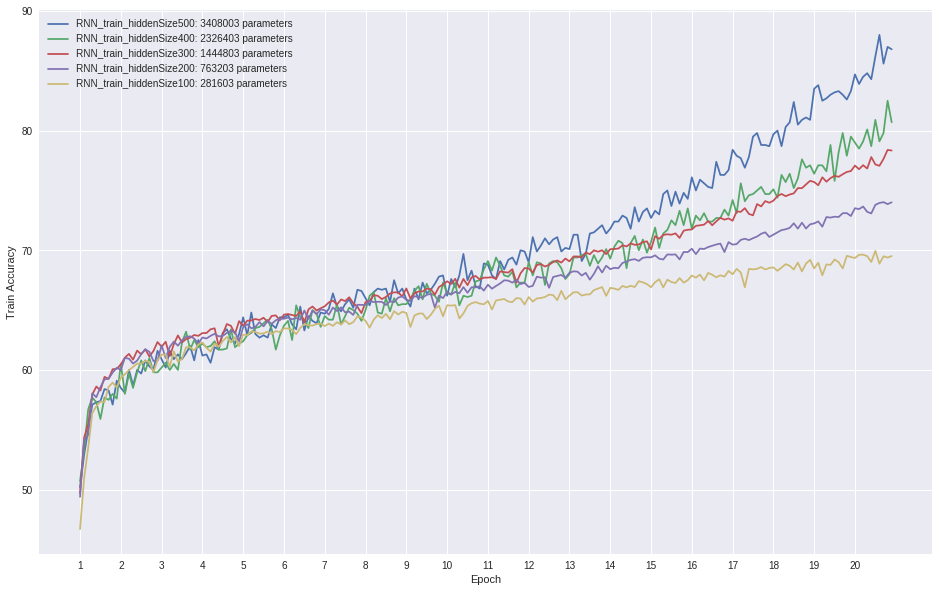

In [204]:
plt.figure(figsize=(16,10))
ax = plt.axes()
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
# ax.plot([item for sublist in RNN_train_hiddenSize500 for item in sublist[0::5]],label = 'RNN_train_hiddenSize500: 3408003 parameters')
# ax.plot([item for sublist in RNN_train_hiddenSize400 for item in sublist[0::5]],label = 'RNN_train_hiddenSize400: 2326403 parameters')
# ax.plot([item for sublist in RNN_train_hiddenSize300 for item in sublist[0::5]],label = 'RNN_train_hiddenSize300: 1444803 parameters')
# ax.plot([item for sublist in RNN_train_hiddenSize200 for item in sublist[0::5]], label = 'RNN_train_hiddenSize200: 763203 parameters')
# ax.plot([item for sublist in RNN_train_hiddenSize100 for item in sublist[0::5]], label = 'RNN_train_hiddenSize100: 281603 parameters')
# plt.legend()
# alph = range(1,21,1)
# xs = range(0,40,2)
ax.plot([item for sublist in RNN_train_hiddenSize500 for item in sublist],label = 'RNN_train_hiddenSize500: 3408003 parameters')
ax.plot([item for sublist in RNN_train_hiddenSize400 for item in sublist],label = 'RNN_train_hiddenSize400: 2326403 parameters')
ax.plot([item for sublist in RNN_train_hiddenSize300 for item in sublist],label = 'RNN_train_hiddenSize300: 1444803 parameters')
ax.plot([item for sublist in RNN_train_hiddenSize200 for item in sublist], label = 'RNN_train_hiddenSize200: 763203 parameters')
ax.plot([item for sublist in RNN_train_hiddenSize100 for item in sublist], label = 'RNN_train_hiddenSize100: 281603 parameters')
plt.legend()
alph = range(1,21,1)
xs = range(0,200,10)
ax.set_xticks(xs)
ax.set_xticklabels(alph)
plt.show()

# RNN validation accuracy

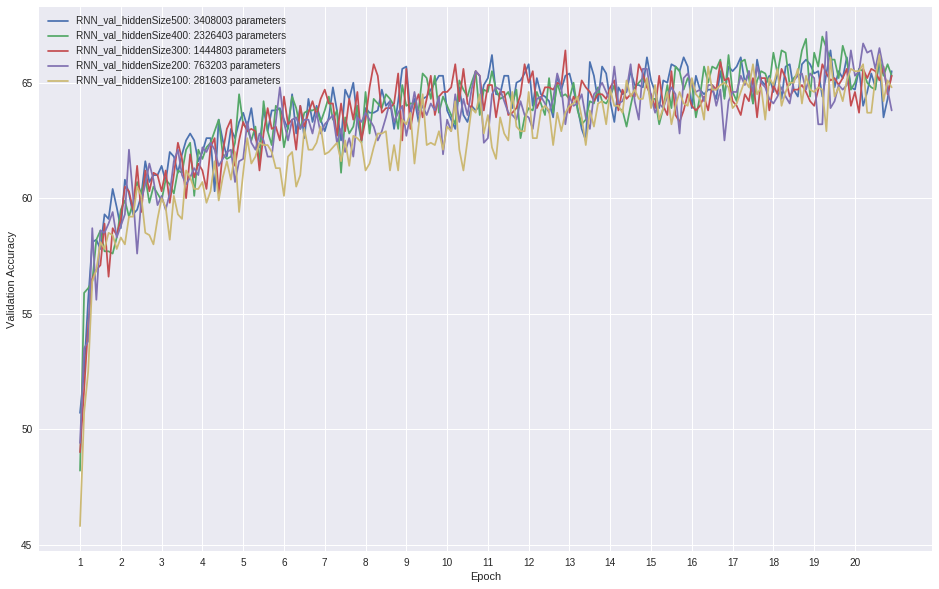

In [203]:
plt.figure(figsize=(16,10))
bx = plt.axes()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
bx.plot([item for sublist in RNN_val_hiddenSize500 for item in sublist],label = "RNN_val_hiddenSize500: 3408003 parameters")
bx.plot([item for sublist in RNN_val_hiddenSize400 for item in sublist],label = "RNN_val_hiddenSize400: 2326403 parameters")
bx.plot([item for sublist in RNN_val_hiddenSize300 for item in sublist],label = "RNN_val_hiddenSize300: 1444803 parameters")
bx.plot([item for sublist in RNN_val_hiddenSize200 for item in sublist],label = "RNN_val_hiddenSize200: 763203 parameters")
bx.plot([item for sublist in RNN_val_hiddenSize100 for item in sublist],label = "RNN_val_hiddenSize100: 281603 parameters")
pylab.legend(loc='upper left')
alph = range(1,21,1)
xs = range(0,200,10)
bx.set_xticks(xs)
bx.set_xticklabels(alph)
plt.show()

In [0]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, kernel_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding, num_embeddings, emb_size = create_emb_layer(weights_matrix, False)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size - 1)/2))
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size - 1)/2))
        
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
        
    def forward(self, x1,x2, lengths1,lengths2):
        batch_size, seq_len1 = x1.size()
          # 32 82
        batch_size, seq_len2 = x2.size()
          # 32 41
        embed1 = self.embedding(x1)
  
          # 32*82*300
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
          # 32*82*200
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
          # [32, 82, 200]
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
          # [32, 41, 200]
        
        pool1 = nn.MaxPool1d(82, stride=1, padding= 0)
        afterPool1 = pool1(hidden1.transpose(1,2)).transpose(1,2).squeeze(dim = 1)
        
        pool2 = nn.MaxPool1d(41, stride=1, padding= 0)
        afterPool2 = pool2(hidden2.transpose(1,2)).transpose(1,2).squeeze(dim = 1)        
        
        combined_vector = torch.cat([afterPool1, afterPool2], dim=1) # 32*200 + 32*200 = 32*400
        combined_vector = combined_vector.cuda()

        fc1_output = self.fc1(combined_vector) # 32*800 到 32*200
        non_linear = self.relu(fc1_output)
        fc2_output = self.fc2(non_linear)     # 32*200 到 32*3
        return fc2_output
      
def tuningCNN(hidden_size,kernel_size):
    learning_rate = 3e-4
    num_epochs = 20 # number epoch to train


    # Train the model
    model = CNN(embedding_matrix, hidden_size = hidden_size, num_layers = 2, num_classes = 3, kernel_size = kernel_size)
    model = model.cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc_list =[]
    val_acc_list = []
    highest_val_acc = 0
    
    for epoch in range(num_epochs):
        train_acc_list.append([])
        val_acc_list.append([])
        for i, (data1, data2,lengths1,lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2,lengths1,lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            if i > 0 and i % 300 == 0:
                # validate
                train_acc = test_model(subset_train_loader, model)
                val_acc = test_model(val_loader, model)
                if val_acc > highest_val_acc:
                    highest_val_acc = val_acc
                    torch.save(model.state_dict(), "/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize{}_kernelSize{}".format(hidden_size,kernel_size))
                    
                train_acc_list[epoch].append(float(train_acc))
                val_acc_list[epoch].append(val_acc)
                
    idx = val_acc_list.index(max(val_acc_list))
    print("The best model is with Loss: {}, Validation Acc: {}".format(train_acc_list[idx],val_acc_list[idx]))
    
    return train_acc_list,val_acc_list

In [0]:
grid = {'hidden_size':[300,400,500],'kernel_size':[3,5,7]}
num_comb = len(ParameterGrid(grid))

count = 0

for j in range(len(ParameterGrid(grid))):
    count += 1
    print("Now it is {} out of {} combinations".format(count, num_comb))
    kernel_size,hidden_size = ParameterGrid(grid)[j].values()
    myCsvRow = "kernel_size = {},hidden_size = {}".format(kernel_size,hidden_size)
    print(myCsvRow)
    CNN_train, CNN_val = tuningCNN(hidden_size,kernel_size)
    pkl.dump(CNN_train, open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize{}_kernelSize{}.p".format(hidden_size,kernel_size),'wb'))
    pkl.dump(CNN_val, open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize{}_kernelSize{}.p".format(hidden_size,kernel_size),'wb'))

# Restore CNN

In [215]:
loaded_model = CNN(embedding_matrix, hidden_size = 500, num_layers = 1, num_classes = 3, kernel_size = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize500_kernelSize3"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 500, num_layers = 1, num_classes = 3, kernel_size = 5)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize500_kernelSize5"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 500, num_layers = 1, num_classes = 3, kernel_size = 7)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize500_kernelSize7"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 300, num_layers = 1, num_classes = 3, kernel_size = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize300_kernelSize3"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 300, num_layers = 1, num_classes = 3, kernel_size = 5)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize300_kernelSize5"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 300, num_layers = 1, num_classes = 3, kernel_size = 7)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize300_kernelSize7"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 400, num_layers = 1, num_classes = 3, kernel_size = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize400_kernelSize3"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 400, num_layers = 1, num_classes = 3, kernel_size = 5)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize400_kernelSize5"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

loaded_model = CNN(embedding_matrix, hidden_size = 400, num_layers = 1, num_classes = 3, kernel_size = 7)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize400_kernelSize7"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))
print("number of trained parameters:",sum(p.numel() for p in loaded_model.parameters() if p.requires_grad))

65.4
number of trained parameters: 16703603
65.1
number of trained parameters: 17503603
65.0
number of trained parameters: 18303603
65.6
number of trained parameters: 15722403
65.4
number of trained parameters: 16082403
65.0
number of trained parameters: 16442403
64.9
number of trained parameters: 16163003
65.8
number of trained parameters: 16723003
65.5
number of trained parameters: 17283003


In [0]:
CNN_train_hiddenSize400_kernelSize7 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize400_kernelSize7.p", "rb"))
CNN_val_hiddenSize400_kernelSize7 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize400_kernelSize7.p", "rb"))

CNN_train_hiddenSize400_kernelSize5 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize400_kernelSize5.p", "rb"))
CNN_val_hiddenSize400_kernelSize5 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize400_kernelSize5.p", "rb"))

CNN_train_hiddenSize400_kernelSize3 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize400_kernelSize3.p", "rb"))
CNN_val_hiddenSize400_kernelSize3 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize400_kernelSize3.p", "rb"))

CNN_train_hiddenSize300_kernelSize7 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize300_kernelSize7.p", "rb"))
CNN_val_hiddenSize300_kernelSize7 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize300_kernelSize7.p", "rb"))

CNN_train_hiddenSize300_kernelSize5 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize300_kernelSize5.p", "rb"))
CNN_val_hiddenSize300_kernelSize5 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize300_kernelSize5.p", "rb"))

CNN_train_hiddenSize300_kernelSize3 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize300_kernelSize3.p", "rb"))
CNN_val_hiddenSize300_kernelSize3 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize300_kernelSize3.p", "rb"))

CNN_train_hiddenSize500_kernelSize7 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize500_kernelSize7.p", "rb"))
CNN_val_hiddenSize500_kernelSize7 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize500_kernelSize7.p", "rb"))

CNN_train_hiddenSize500_kernelSize5 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize500_kernelSize5.p", "rb"))
CNN_val_hiddenSize500_kernelSize5 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize500_kernelSize5.p", "rb"))

CNN_train_hiddenSize500_kernelSize3 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_train_hiddenSize500_kernelSize3.p", "rb"))
CNN_val_hiddenSize500_kernelSize3 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/CNN_val_hiddenSize500_kernelSize3.p", "rb"))



# CNN Train Accuracy Plot

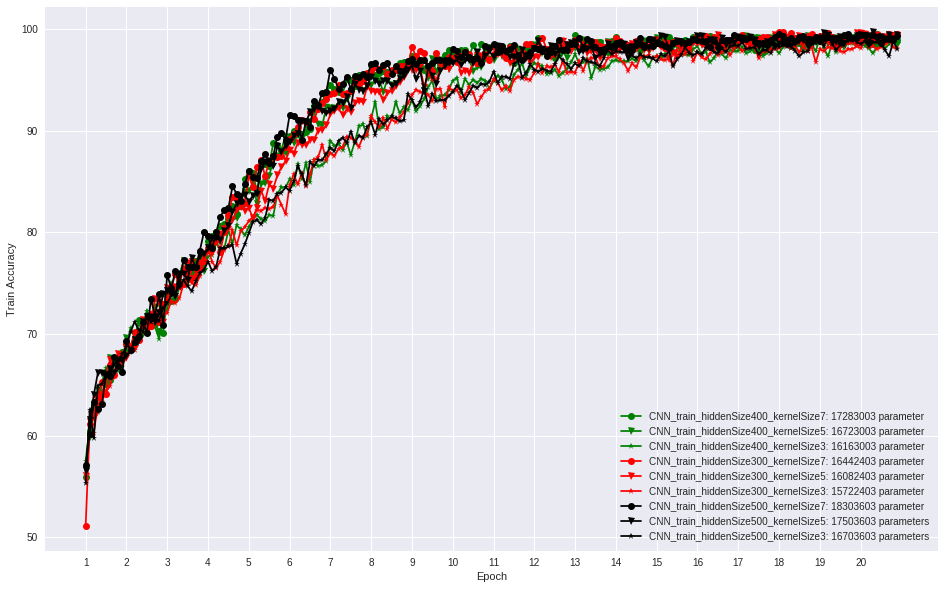

In [223]:
plt.figure(figsize=(16,10))
ax = plt.axes()
plt.xlabel("Epoch")  
plt.ylabel("Train Accuracy")
ax.plot([item for sublist in CNN_train_hiddenSize400_kernelSize7 for item in sublist],color='green', marker='o', label = 'CNN_train_hiddenSize400_kernelSize7: 17283003 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize400_kernelSize5 for item in sublist],color='green', marker='v', label = 'CNN_train_hiddenSize400_kernelSize5: 16723003 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize400_kernelSize3 for item in sublist], color='green', marker='*',label = 'CNN_train_hiddenSize400_kernelSize3: 16163003 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize300_kernelSize7 for item in sublist], color='red', marker='o', label = 'CNN_train_hiddenSize300_kernelSize7: 16442403 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize300_kernelSize5 for item in sublist], color='red', marker='v',label = 'CNN_train_hiddenSize300_kernelSize5: 16082403 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize300_kernelSize3 for item in sublist], color='red', marker='*',label = 'CNN_train_hiddenSize300_kernelSize3: 15722403 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize500_kernelSize7 for item in sublist], color='black', marker='o',label = 'CNN_train_hiddenSize500_kernelSize7: 18303603 parameter')
ax.plot([item for sublist in CNN_train_hiddenSize500_kernelSize5 for item in sublist], color='black', marker='v',label = 'CNN_train_hiddenSize500_kernelSize5: 17503603 parameters')
ax.plot([item for sublist in CNN_train_hiddenSize500_kernelSize3 for item in sublist], color='black', marker='*',label = 'CNN_train_hiddenSize500_kernelSize3: 16703603 parameters')
plt.legend()
alph = range(1,21,1)
xs = range(0,200,10)
ax.set_xticks(xs)
ax.set_xticklabels(alph)
plt.show()

# CNN Validation Accuracy Plot

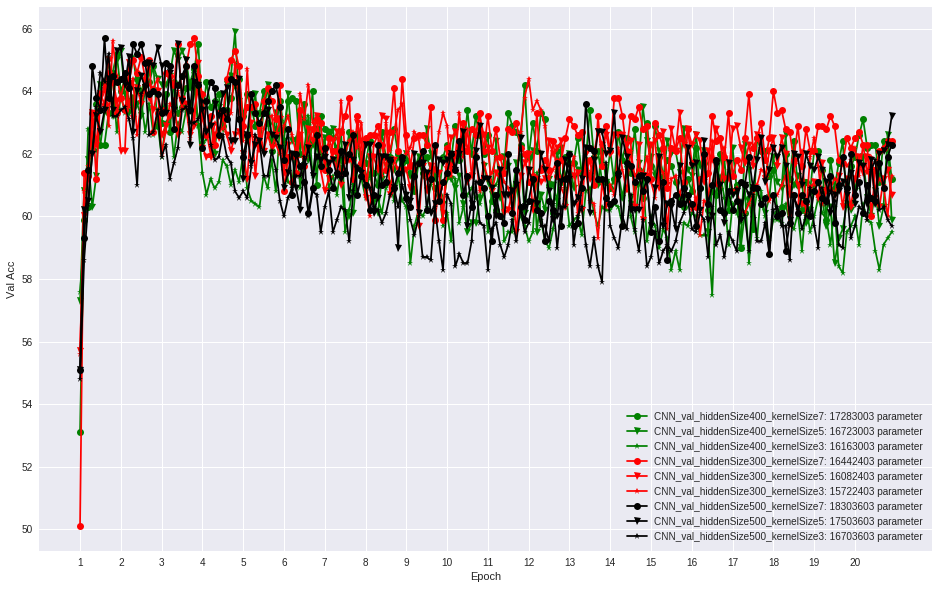

In [225]:
plt.figure(figsize=(16,10))
bx = plt.axes()
plt.xlabel("Epoch")
plt.ylabel("Val Acc")
bx.plot([item for sublist in CNN_val_hiddenSize400_kernelSize7 for item in sublist], color='green', marker='o',label = 'CNN_val_hiddenSize400_kernelSize7: 17283003 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize400_kernelSize5 for item in sublist], color='green', marker='v',label = 'CNN_val_hiddenSize400_kernelSize5: 16723003 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize400_kernelSize3 for item in sublist], color='green', marker='*',label = 'CNN_val_hiddenSize400_kernelSize3: 16163003 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize300_kernelSize7 for item in sublist], color='red', marker='o',label = 'CNN_val_hiddenSize300_kernelSize7: 16442403 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize300_kernelSize5 for item in sublist], color='red', marker='v',label = 'CNN_val_hiddenSize300_kernelSize5: 16082403 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize300_kernelSize3 for item in sublist], color='red', marker='*',label = 'CNN_val_hiddenSize300_kernelSize3: 15722403 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize500_kernelSize7 for item in sublist], color='black', marker='o',label = 'CNN_val_hiddenSize500_kernelSize7: 18303603 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize500_kernelSize5 for item in sublist], color='black', marker='v',label = 'CNN_val_hiddenSize500_kernelSize5: 17503603 parameter')
bx.plot([item for sublist in CNN_val_hiddenSize500_kernelSize3 for item in sublist], color='black', marker='*',label = 'CNN_val_hiddenSize500_kernelSize3: 16703603 parameter')
plt.legend()
alph = range(1,21,1)
xs = range(0,200,10)
bx.set_xticks(xs)
bx.set_xticklabels(alph)
plt.show()

# Best RNN Model Train and Validation Accuracy Plot

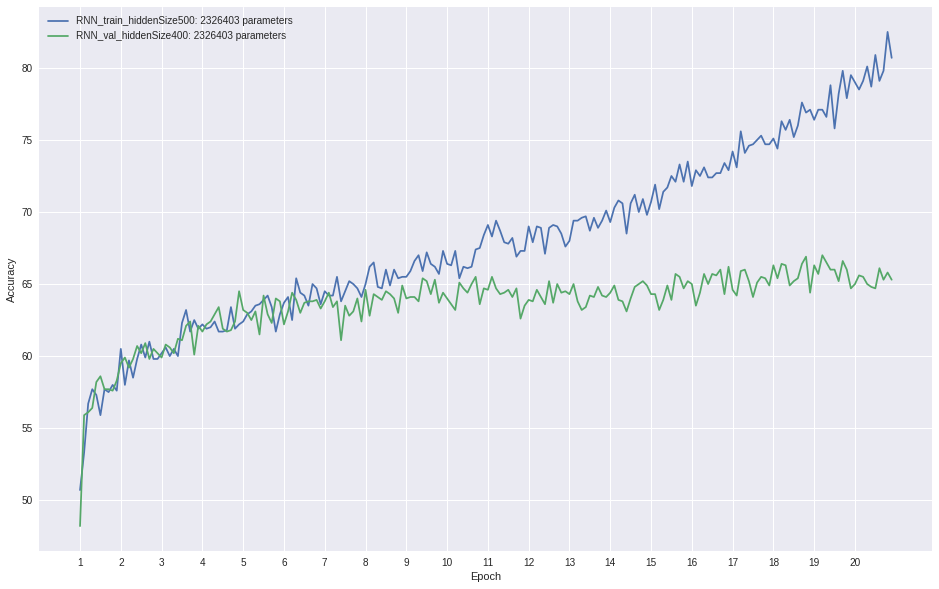

In [214]:
RNN_train_hiddenSize400 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_train_hiddenSize400.p", "rb"))
RNN_val_hiddenSize400 = pkl.load(open("/content/drive/My Drive/nlp-hw2/New_Models/RNN_val_hiddenSize400.p", "rb"))

plt.figure(figsize=(16,10))
bx = plt.axes()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
bx.plot([item for sublist in RNN_train_hiddenSize400 for item in sublist],label = "RNN_train_hiddenSize500: 2326403 parameters")
bx.plot([item for sublist in RNN_val_hiddenSize400 for item in sublist],label = "RNN_val_hiddenSize400: 2326403 parameters")

pylab.legend(loc='upper left')
alph = range(1,21,1)
xs = range(0,200,10)
bx.set_xticks(xs)
bx.set_xticklabels(alph)
plt.show()

# 3 correct and 3 incorrect examples

In [0]:
loaded_model = RNN(embedding_matrix, hidden_size = 400, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize400"))
loaded_model = loaded_model.cuda()
loaded_model.eval()

index = []
for data1, lengths1, data2, lengths2, labels in val_loader:
    data_batch1, lengths_batch1, data_batch2, lengths_batch2, label_batch = data1, lengths1, data2, lengths2, labels
    outputs = F.softmax(loaded_model(data_batch1.cpu(), lengths_batch1.cpu(), data_batch2.cpu(), lengths_batch2.cpu()), dim=1)
    predicted = outputs.max(1, keepdim=True)[1].cpu()
    index += (predicted.numpy() == labels.cpu().view_as(predicted).numpy()).tolist()
    break

correct = []
incorrect = []
for i, val in enumerate(index):
    if val[0] == True:
        correct.append(i)
    else:
        incorrect.append(i)

In [179]:
print("3 correct examples:")
for i in correct[0:3]:
    print("premise:",snli_val.sentence1[i])
    print("hypothesis:",snli_val.sentence2[i])
    print("true label",snli_val.label[i])
    
print("\n3 incorrect examples")
for i in incorrect[0:3]:
    print("premise:",snli_val.sentence1[i])
    print("hypothesis:",snli_val.sentence2[i])
    print("true label:",snli_val.label[i])
    print("prediction:",int(predicted[i]))
    

3 correct examples:
premise: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
hypothesis: There are two women standing on the stage
true label 2
premise: Man in overalls with two horses .
hypothesis: a man in overalls with two horses
true label 1
premise: Two women , one walking her dog the other pushing a stroller .
hypothesis: There is a snowstorm .
true label 2

3 incorrect examples
premise: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
hypothesis: Multiple people are on a subway together , with each of them doing their own thing .
true label: 1
prediction: 0
premise: bicycles stationed while a group of people socialize .
hypothesis: People get together near a stand of bicycles .
true label: 1
prediction: 0
premise: Man observes a wa

# Process MNLI DataSet

In [0]:
d = {
    'telephone': 0,
    'fiction': 1,
    'slate': 2,
    'government':3,
    'travel':4
}

mnli_train["genre"] = mnli_train["genre"].map(d)
mnli_val["genre"] = mnli_val["genre"].map(d)

## sentence 1 and sentence2 sorted length

print("sentence 1 length rank:",sorted([len(i.split(" ")) for i in mnli_val.sentence1],reverse = True))
print("sentence 2 length rank:",sorted([len(i.split(" ")) for i in mnli_val.sentence2],reverse = True))

## only 32 out of 50000 sentence 1 is greater than 82, so I will remove these 32 sentences
print("Total number of sentence 1 whose length > 82:",sum(sorted([len(i.split(" ")) > 82 for i in mnli_val.sentence1],reverse = True)))

## only 2 out of 50000 sentence 1 is greater than 82, so I will remove these 2 sentences
print("Total number of sentence 2 whose length > 41:",sum(sorted([len(i.split(" ")) > 41 for i in mnli_val.sentence2],reverse = True)))    

In [0]:
### Remove sentence 1 whose length is greater than 82 and sentence 2 > 41
for idx in range(len(mnli_train)):
    if len(mnli_train.sentence1[idx].split(" ")) > 82 or len(mnli_train.sentence2[idx].split(" ")) > 41:
        mnli_train.drop(idx,inplace = True)
        
### Remove sentence 1 whose length is greater than 82 and sentence 2 > 41
for idx in range(len(mnli_val)):
    if len(mnli_val.sentence1[idx].split(" ")) > 82 or len(mnli_val.sentence2[idx].split(" ")) > 41:
        mnli_val.drop(idx,inplace = True)

# Load CNN Best Model Evaluating MNLI

In [30]:
loaded_model = CNN(embedding_matrix, hidden_size = 400, num_layers = 1, num_classes = 3, kernel_size = 5)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/CNN_hiddenSize400_kernelSize5"))
loaded_model = loaded_model.cuda()
loaded_model.eval()
print(test_model(val_loader, loaded_model))

for i in range(0,5):
    temp_val = mnli_val[mnli_val["genre"] == i]
    print("genre {}".format(i))
    temp_val_val_sent1_indices = token2index_dataset(temp_val.sentence1)
    temp_val_val_sent2_indices = token2index_dataset(temp_val.sentence2)
#     max_sent1_len = max([len(i) for i in mnli_val_sent1_indices])
#     max_sent2_len = max([len(i) for i in mnli_val_sent2_indices])
    max_sent1_len = 82
    max_sent2_len = 41
    val_targets = list(temp_val.label)
    val_dataset = VocabDataset(temp_val_val_sent1_indices, temp_val_val_sent2_indices,val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Vocab_collate_func,
                                           shuffle=True)
    loaded_model.eval()
    print(test_model(val_loader, loaded_model))

43.52701325178389
genre 0
43.743641912512714
genre 1
41.229838709677416
genre 2
41.4
genre 3
41.68316831683168
genre 4
43.52701325178389


# Load RNN Best Model Evaluating MNLI

In [134]:
loaded_model = RNN(embedding_matrix, hidden_size = 200, num_layers = 1, num_classes = 3)
#Later to restore:
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/nlp-hw2/New_Models/RNN_hiddenSize200"))
loaded_model = loaded_model.cuda()
loaded_model.eval()

for i in range(0,5):
    temp_val = mnli_val[mnli_val["genre"] == i]
    print("genre {}".format(i))
    temp_val_val_sent1_indices = token2index_dataset(temp_val.sentence1)
    temp_val_val_sent2_indices = token2index_dataset(temp_val.sentence2)
#     max_sent1_len = max([len(i) for i in mnli_val_sent1_indices])
#     max_sent2_len = max([len(i) for i in mnli_val_sent2_indices])
    max_sent1_len = 82
    max_sent2_len = 41
    val_targets = list(temp_val.label)
    val_dataset = VocabDataset(temp_val_val_sent1_indices, temp_val_val_sent2_indices,val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Vocab_collate_func,
                                           shuffle=True)
    loaded_model.eval()
    print(test_model(val_loader, loaded_model))

genre 0
41.99004975124378
genre 1
42.21105527638191
genre 2
43.91217564870259
genre 3
46.06299212598425
genre 4
43.38085539714868


# Fine-tune RNN model on Mnli

In [0]:
def fine_tune(saved_model, train, val):
    num_epochs = 5
    learning_rate = 1e-4
    
    for i in range(0,5):
        temp_train = mnli_train[mnli_train['genre'] ==i]
        temp_val = mnli_val[mnli_val["genre"] == i]
        print("genre {}".format(i))
        
        temp_train_sent1_indices = token2index_dataset(temp_train.sentence1)
        temp_train_sent2_indices = token2index_dataset(temp_train.sentence2)
        temp_val_sent1_indices = token2index_dataset(temp_val.sentence1)
        temp_val_sent2_indices = token2index_dataset(temp_val.sentence2)
        max_sent1_len = 82
        max_sent2_len = 41
        train_targets = list(temp_train.label)
        train_dataset = VocabDataset(temp_train_sent1_indices, temp_train_sent2_indices,train_targets)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=Vocab_collate_func,
                                               shuffle=True)
        val_targets = list(temp_val.label)
        val_dataset = VocabDataset(temp_val_sent1_indices, temp_val_sent2_indices,val_targets)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=Vocab_collate_func,
                                               shuffle=True)
  
        # Train the model
        model = saved_model
        model = model.cuda()
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()
        criterion = criterion.cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        highest_val_acc = 0

        for epoch in range(num_epochs):
            for i, (data1, data2,lengths1,lengths2, labels) in enumerate(train_loader): 
                model.train()
                optimizer.zero_grad()
                # Forward pass
                outputs = model(data1, data2,lengths1,lengths2)
                loss = criterion(outputs, labels)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                if i > 0 and i % 10 == 0:
                    # validate
#                     train_acc = test_model(subset_train_loader, model)
                    val_acc = test_model(val_loader, model)
                    if val_acc > highest_val_acc:
                        highest_val_acc = val_acc
                        torch.save(model.state_dict(), "/content/drive/My Drive/nlp-hw2/New_Models/Fine_tune_RNN_genre{}".format(i))

#                     print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                         epoch+1, num_epochs, i+1, len(train_loader),val_acc))
        print("The best model has Validation Acc: {}".format(highest_val_acc))

In [112]:
fine_tune(loaded_model, mnli_train, mnli_val)

genre 0
The best model has Validation Acc: 53.134328358208954
genre 1
The best model has Validation Acc: 52.26130653266332
genre 2
The best model has Validation Acc: 48.60279441117765
genre 3
The best model has Validation Acc: 55.41338582677165
genre 4
The best model has Validation Acc: 54.175152749490834
